In [1]:
import os, time
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torch.nn.functional as F
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
now = int(time.time())

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 64
num_epochs = 1000

z_dimension = 100

In [6]:
device_ids = [0] #, 1]

In [7]:
wh = 64
img_transform = transforms.Compose([
    transforms.Resize(wh),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

# dataset = datasets.ImageFolder('~/data/anime-faces', transform=img_transform)
dataset = datasets.ImageFolder('~/data/faceimgs', transform=img_transform) # https://lab.grapeot.me/faceimgs.tar
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [8]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(SelfAttention,self).__init__()
        
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
        
    def forward(self, x):
        
        m_batchsize, C, width ,height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1) # B (N) C
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height) # B C (N)
        energy = torch.bmm(proj_query, proj_key) # transpose check
        attention = self.softmax(energy) # B (N) (N) 
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height) # B C N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # B C N
        out = out.view(m_batchsize, C, width, height) # B C W H
        
        out = self.gamma * out + x
        return out, attention

In [9]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(1, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

In [10]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [11]:
class Discriminator(nn.Module): # b 3 64 64
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3, d, 4, 2, 1)),
            nn.BatchNorm2d(d), # sagan not use: not working may be
            nn.LeakyReLU(.2, True),
        ) # b d 32 32
        
        self.conv2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(d, d*2, 4, 2, 1)),
            nn.BatchNorm2d(d*2), #
            nn.LeakyReLU(.2, True),
        ) # b d*2 16 16
        
        self.conv3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(d*2, d*4, 4, 2, 1)),
            nn.BatchNorm2d(d*4), #
            nn.LeakyReLU(.2, True),
        ) # b d*4 8 8
        
        self.conv4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(d*4, d*8, 4, 2, 1)),
            nn.BatchNorm2d(d*8), #
            nn.LeakyReLU(.2, True),
        ) # b d*8 4 4
        
        self.conv5 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(d*8, d*16, 4, 2, 1)),
            nn.BatchNorm2d(d*16), #
            nn.LeakyReLU(.2, True),
        ) # b d*16 2 2
        
#         self.conv6 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(d*16, d*32, 4, 2, 2)),
#             nn.BatchNorm2d(d*32),
#             nn.LeakyReLU(.2, True),
#         ) # b d*32 2 2
        
        
#         self.output = nn.Sequential(
#             nn.Conv2d(d*16, 1, 4, 2, 1),
#             nn.Sigmoid(),
#         ) # b 1 1 1
        
#         self.output = nn.Sequential( # out of memory
#             nn.Linear(d * 16 * 2 * 2, 1),
#             nn.Sigmoid(),
#         )

        self.output = nn.Sequential(
            nn.Conv2d(d*16, d, 1, 1, 1),
            nn.BatchNorm2d(d), # b d 2 2
#             nn.LeakyReLU(d, True),
            
        )
        self.output_l = nn.Sequential(
            nn.Linear(d * 4 * 4, 1),
            nn.Sigmoid(),
        )
        
        self.att1 = SelfAttention(d)
#         self.att1 = SelfAttention(d*16)
        

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x): # b 3 w h
        out = self.conv1(x)
        out, p1 = self.att1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
#         out, p1 = self.att2(out)
#         out = self.conv6(out)
        return self.output_l(self.output(out).reshape(x.size(0), -1)).reshape(x.size(0), -1)
#         return self.output(out.view(x.size(0), -1)).reshape(x.size(0), -1)

# class Discriminator(nn.Module):
#     def __init__(self, d=128):
#         super(Discriminator, self).__init__() # b d 64 64
        
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, d, 4, 2, 2),
#             nn.LeakyReLU(.2, True),
#             nn.BatchNorm2d(d),
#         ) # d 32 32
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(d, d*2, 4, 2, 2),
#             nn.LeakyReLU(.2, True),
#             nn.BatchNorm2d(d*2),
#         ) # d 16 16
        
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(d*2, d*4, 4, 2, 1),
#             nn.LeakyReLU(.2, True),
#             nn.BatchNorm2d(d*4),
#         ) # d*4 8 8
        
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(d*4, d*8, 4, 2, 1),
#             nn.LeakyReLU(.2, True),
#             nn.BatchNorm2d(d*8),
#         ) # d*4 4 4
        
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(d*8, d*16, 4, 2, 1),
#             nn.LeakyReLU(.2, True),
#             nn.BatchNorm2d(d*16),
#         ) # d*4 2 2
        
        
#         self.output = nn.Sequential(
#             nn.Conv2d(d*16, 1, 4, 2, 1),
#             nn.Sigmoid(),
#         ) # 1 1 1
        
#     def weight_init(self, mean, std):
#         for m in self._modules:
#             normal_init(self._modules[m], mean, std)
            
#     def forward(self, x): # b 1 32 32

#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.conv5(out)
        
#         out = self.output(out)
        
#         return out

In [12]:
class Generator(nn.Module):
    def __init__(self, inp_dim, d=64):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(inp_dim, d*16, 4, 2, 1)),
            nn.BatchNorm2d(d*16),
            nn.ReLU(True),
        ) # b d*16 2 2
        
        self.deconv2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(d*16, d*8, 4, 2, 1)),
            nn.BatchNorm2d(d*8),
            nn.ReLU(True),
        ) # b d*8 4 4
        
        self.deconv3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)),
            nn.BatchNorm2d(d*4),
            nn.ReLU(True),
        ) # b d*4 8 8
        
        self.deconv4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)),
            nn.BatchNorm2d(d*2),
            nn.ReLU(True),
        ) # b d*2 16 16
        
        self.deconv5 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(d*2, d, 4, 2, 1)),
            nn.BatchNorm2d(d),
            nn.ReLU(True),
        ) # b d 32 32
        
#         self.deconv6 = nn.Sequential(
#             nn.ConvTranspose2d(d*2, d, 4, 2, 1),
#             nn.BatchNorm2d(d),
#             nn.ReLU(True),
#         ) # b d 32 32
        
        self.output = nn.Sequential(
            nn.ConvTranspose2d(d, 3, 4, 2, 1),
            nn.Tanh(),
        ) # b 3 64 64
        
#         self.output = nn.Sequential( # out of memory
#             nn.Linear(d * 32 * 32, 3 * 64 * 64),
#             nn.Tanh(),
#         ) # b 3 64 64
        
#         self.att1 = SelfAttention(d*16)
        self.att1 = SelfAttention(d)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x):
        out = self.deconv1(x)
#         out, p1 = self.att1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        out = self.deconv4(out)
        out = self.deconv5(out)
        out, p1 = self.att1(out)
#         out = self.deconv6(out)

        out = self.output(out)
#         out = self.output(out.view(x.size(0), -1)).reshape(x.size(0), 3, 64, 64)
        
        return out

# class Generator(nn.Module):
#     def __init__(self, z_dimension, d=128):
#         super(Generator, self).__init__()
        
#         self.upsample1 = nn.Sequential(
#             nn.ConvTranspose2d(z_dimension, d*16, 4, 2, 1),
#             nn.BatchNorm2d(d*16),
#             nn.ReLU(True),
#         ) # b d 2 2 
        
#         self.upsample2 = nn.Sequential(
#             nn.ConvTranspose2d(d*16, d*8, 4, 2, 1),
#             nn.BatchNorm2d(d*8),
#             nn.ReLU(True),
#         ) # b d*8 4 4
        
#         self.upsample3 = nn.Sequential(
#             nn.ConvTranspose2d(d*8, d*4, 4, 2, 1),
#             nn.BatchNorm2d(d*4),
#             nn.ReLU(True),
#         ) # b d*8 8 8
        
#         self.upsample4 = nn.Sequential(
#             nn.ConvTranspose2d(d*4, d*2, 4, 2, 1),
#             nn.BatchNorm2d(d*2),
#             nn.ReLU(True),
#         ) # b d*2 16 16
        
#         self.upsample5 = nn.Sequential(
#             nn.ConvTranspose2d(d*2, d, 4, 2, 1),
#             nn.BatchNorm2d(d),
#             nn.ReLU(True),
#         ) # b d 32 32
        
#         self.output = nn.Sequential(
#             nn.ConvTranspose2d(d, 3, 4, 2, 1),
#             nn.Tanh(),
#         ) # b 3 64 64
        
#     def weight_init(self, mean, std):
#         for m in self._modules:
#             normal_init(self._modules[m], mean, std)
            
#     def forward(self, x): # b 100 1 1

#         outs = self.upsample1(x)
#         outs = self.upsample2(outs)
#         outs = self.upsample3(outs)
#         outs = self.upsample4(outs)
#         outs = self.upsample5(outs)
        
#         outs = self.output(outs)

#         return outs

In [13]:
d = Discriminator(d=64)#.cuda(device_ids[0])
g = Generator(z_dimension, d=64)#.cuda(device_ids[0])

# d.weight_init(0.0, 0.02)
# g.weight_init(0.0, 0.02)

d = nn.DataParallel(d, device_ids=device_ids).to(device)
g = nn.DataParallel(g, device_ids=device_ids).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=1e-4) # 2e-4
# d_optimezer = nn.DataParallel(d_optimezer, device_ids=device_ids)
g_optimezer = optim.Adam(g.parameters(), lr=1e-4) # 2e-4
# g_optimezer = nn.DataParallel(g_optimezer, device_ids=device_ids)

# one = torch.FloatTensor([1])
# mone = one * -1
# one = one.to(device)
# mone = mone.to(device)

In [14]:
writer = SummaryWriter(os.path.join('./log/cnn_wgan_gp_faces', str(now)))

In [15]:
img_path = os.path.join("save_images/cnn_wgan_gp_faces", str(now))
if not os.path.exists(img_path): os.makedirs(img_path)

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    
    d_loss_total = .0
    g_loss_total = .0
    _step = epoch * total_count
    for i, (img, _) in enumerate(dataloader):
        
        real_img = img.cuda()
        z = torch.randn(img.size(0), z_dimension, 1, 1).cuda()
        
#         real_labels = torch.ones(img.size(0), 1).cuda()
#         fake_labels = torch.zeros(img.size(0), 1).cuda()
        
#         real_labels = torch.from_numpy(np.random.normal(.95, .02, [img.size(0), 1])).float().to(device)
#         fake_labels = torch.from_numpy(np.random.normal(.05, .02, [img.size(0), 1])).float().to(device)
        
        ################### G ###################
        fake_img = g(z)
        fake_out = d(fake_img)
        
        g_loss = -fake_out.mean()
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        #########################################
        
        ################### D ###################
        real_out = d(real_img)
        d_loss_real = real_out.mean()
        real_scores = real_out
        
        fake_out = d(fake_img.detach())
        d_loss_fake = fake_out.mean()
        fake_scores = fake_out
        
        gradient_penalty = calc_gradient_penalty(d, real_img, fake_img)
        
        d_loss = d_loss_fake - d_loss_real + gradient_penalty
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        #########################################

        ################### G ###################
#         fake_img = g(z)
#         fake_out = d(fake_img)
#         g_loss = criterion(fake_out, real_labels)
        
#         g_optimezer.zero_grad()
#         g_loss.backward()
#         g_optimezer.step()
        #########################################
        
        ################### D ###################
#         real_out = d(real_img)
#         d_loss_real = criterion(real_out, real_labels)
#         real_scores = real_out
        
#         fake_out = d(fake_img.detach())
#         d_loss_fake = criterion(fake_out, fake_labels)
#         fake_scores = fake_out
        
#         d_loss = d_loss_real + d_loss_fake
#         d_optimezer.zero_grad()
#         d_loss.backward()
#         d_optimezer.step()
        #########################################
        
        w_dist = d_loss_fake - d_loss_real
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 200 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}, W: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean(), w_dist))
        
        if (i + 1) % 300 == 0:
            fake_images = fake_img.view(-1, 3, wh, wh)[:8].cpu().data
            save_image(fake_images, os.path.join(img_path, 'fake_images_{:04d}_{:06d}.png'.format(epoch + 1, i + 1)))
        
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    setp = (epoch + 1) * total_count
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    tqdm.write("Finish Epoch [{}/{}], Mean D Loss: {:.6f}, Mean G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    if epoch == 0:
        real_images = real_img.view(-1, 3, wh, wh).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))

    fake_images = fake_img.view(-1, 3, wh, wh).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{:03d}.png'.format(epoch + 1)))

Epoch [1/1000], Step:  12800, d_loss: 6.211880, g_loss: -0.949038, real_scores: 0.284025, fake_scores: 0.949038, W: 0.665013
Epoch [1/1000], Step:  25600, d_loss: 2.656843, g_loss: -0.858188, real_scores: 0.514157, fake_scores: 0.858188, W: 0.344031
Epoch [1/1000], Step:  38400, d_loss: 1.397070, g_loss: -0.324284, real_scores: 0.355456, fake_scores: 0.324284, W: -0.031172
Epoch [1/1000], Step:  51200, d_loss: 1.285028, g_loss: -0.435560, real_scores: 0.317769, fake_scores: 0.435560, W: 0.117791
Epoch [1/1000], Step:  64000, d_loss: 2.432863, g_loss: -0.460138, real_scores: 0.480301, fake_scores: 0.460138, W: -0.020164
Epoch [1/1000], Step:  76800, d_loss: 2.032492, g_loss: -0.319934, real_scores: 0.290701, fake_scores: 0.319934, W: 0.029233
Epoch [1/1000], Step:  89600, d_loss: 1.763645, g_loss: -0.765895, real_scores: 0.523705, fake_scores: 0.765895, W: 0.242191
Epoch [1/1000], Step: 102400, d_loss: 1.363760, g_loss: -0.191437, real_scores: 0.198207, fake_scores: 0.191437, W: -0.0067

In [17]:
writer.close()

In [18]:
torch.save(d.state_dict(), './ser/cnn_wgan_gp_faces_discriminator_%s.pt' % str(now))
torch.save(g.state_dict(), './ser/cnn_wgan_gp_faces_generator_%s.pt' % str(now))

In [22]:
d.load_state_dict(torch.load('./ser/cnn_wgan_gp_faces_discriminator_1574063358.pt'))
g.load_state_dict(torch.load('./ser/cnn_wgan_gp_faces_generator_1574063358.pt'))

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.output.0.weight". 
	Unexpected key(s) in state_dict: "module.output.0.weight_orig", "module.output.0.weight_u", "module.output.0.weight_v". 

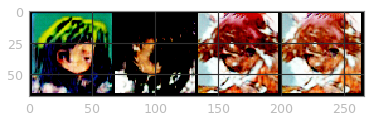

In [21]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

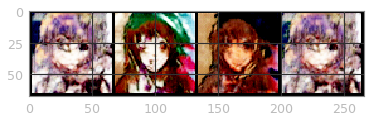

In [19]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

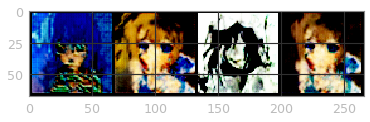

In [20]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

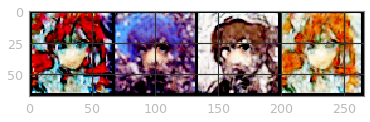

In [26]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()